In [31]:
import numpy as np
import pandas as pd
from tensorflow.keras.applications import ResNet50  # Import ResNet50 instead of MobileNet
from tensorflow.keras.applications.resnet50 import preprocess_input  # Import preprocess_input for ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Dense, BatchNormalization, Flatten, MaxPool2D, GlobalAveragePooling2D
from tensorflow.keras.models import Model 
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, Callback
from keras.layers import Conv2D, Reshape
from keras.utils import Sequence
from keras.backend import epsilon

In [ ]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
from tqdm.notebook import tqdm_notebook as tqdm
import os

In [33]:
print(os.listdir(r"D:\deepfakes\dataset"))

['real_vs_fake', 'test.csv', 'train.csv', 'valid.csv']


In [34]:
# Paths to the real and fake image directories
real = r"D:\deepfakes\dataset\real_vs_fake\real-vs-fake\train\real"
fake = r"D:\deepfakes\dataset\real_vs_fake\real-vs-fake\train\fake"

# List the files in the 'real' and 'fake' directories
real_path = os.listdir(real)
fake_path = os.listdir(fake)

# Optional: To print the paths and verify
print(f"Real images: {real_path[:5]}")  # Print first 5 images in the 'real' directory
print(f"Fake images: {fake_path[:5]}")  # Print first 5 images in the 'fake' directory

Real images: ['00000.jpg', '00002.jpg', '00003.jpg', '00006.jpg', '00009.jpg']
Fake images: ['001DDU0NI4.jpg', '002KDWZBHU.jpg', '002PMM0QG9.jpg', '002TJAKUYX.jpg', '003IRD4LS5.jpg']


## Visualizing the real and fake images

In [35]:
def load_img(path):
    # Read the image
    image = cv2.imread(path)
    
    if image is None:
        print(f"Error: Image not found or could not be opened at {path}")  # More specific error
        return None  # Return None if image loading fails
    
    # Resize to match the input size of ResNet50 (224x224)
    image = cv2.resize(image, (224, 224))  
    
    # Convert BGR to RGB (since OpenCV loads images in BGR format)
    image = image[..., ::-1]  
    
    # Preprocess the image to match ResNet50 input requirements
    image = preprocess_input(image)  # Normalize image for ResNet50
    
    return image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..131.32].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..131.32].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-114.779..145.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-116.68..151.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-102.939..151.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..145.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-109.779..138.061].
Clipping input data

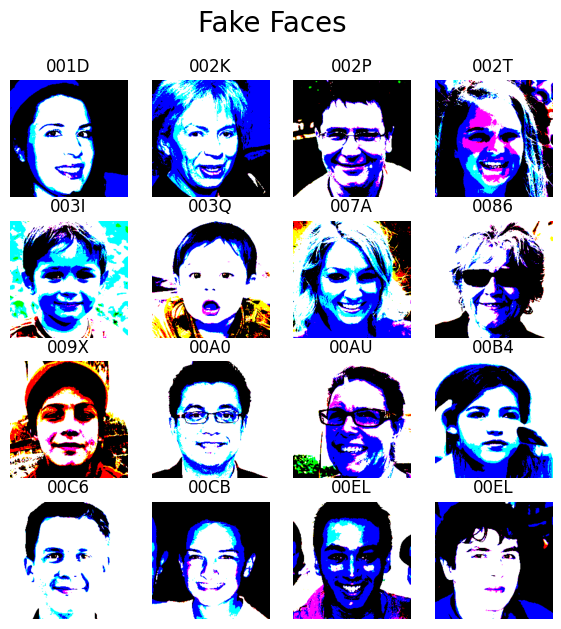

In [36]:
fig = plt.figure(figsize=(7, 7))

# Set the title for the entire figure outside the loop
plt.suptitle("Fake Faces", fontsize=20)

for i in range(16):
    plt.subplot(4, 4, i + 1)
    
    # Use os.path.join to combine the directory and file name
    img_path = os.path.join(fake, fake_path[i])
    img = load_img(img_path)  # Load the image
    
    if img is not None:  # Check if the image is loaded successfully
        plt.imshow(img)  # Display the image
        plt.title(fake_path[i][:4])  # Display a part of the filename as the title
    plt.axis('off')  # Hide the axis

plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..150.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-111.68..139.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..151.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-115.68..150.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-108.68..151.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-119.68..131.32].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-112.68..151.061].
Clipping input data t

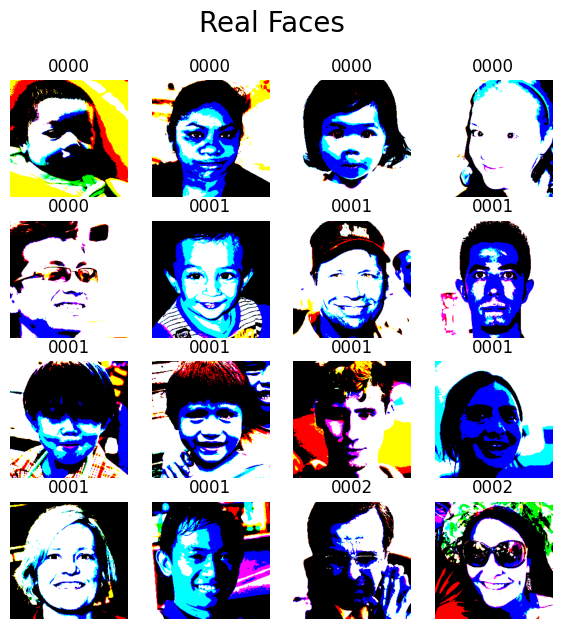

In [37]:
fig = plt.figure(figsize=(7, 7))

# Set the title for the entire figure outside the loop
plt.suptitle("Real Faces", fontsize=20)

for i in range(16):
    plt.subplot(4, 4, i + 1)
    # Use os.path.join to combine the directory and file name
    img_path = os.path.join(real, real_path[i])
    img = load_img(img_path)  # Load the image
    
    if img is not None:  # Check if the image is loaded successfully
        plt.imshow(img)  # Display the image
        plt.title(real_path[i][:4])  # Display a part of the filename as the title
    plt.axis('off')  # Hide the axis

plt.show()

In [38]:
# Define the base path for the dataset
dataset_path = "D:\\deepfakes\\dataset\\real_vs_fake\\real-vs-fake\\train"

# Paths to the real and fake image directories
real = os.path.join(dataset_path, "real")
fake = os.path.join(dataset_path, "fake")

# List the files in the 'real' and 'fake' directories
real_path = os.listdir(real)
fake_path = os.listdir(fake)

# Optional: To print the paths and verify
print(f"Real images: {real_path[:5]}")  # Print first 5 images in the 'real' directory
print(f"Fake images: {fake_path[:5]}")  # Print first 5 images in the 'fake' directory


Real images: ['00000.jpg', '00002.jpg', '00003.jpg', '00006.jpg', '00009.jpg']
Fake images: ['001DDU0NI4.jpg', '002KDWZBHU.jpg', '002PMM0QG9.jpg', '002TJAKUYX.jpg', '003IRD4LS5.jpg']


## Data Augmentation

In [39]:
data_with_aug = ImageDataGenerator(
    horizontal_flip=True,
    vertical_flip=True,  # Vertical flip
    rotation_range=30,  # Random rotations
    zoom_range=0.2,  # Random zoom
    width_shift_range=0.2,  # Random horizontal shift
    height_shift_range=0.2,  # Random vertical shift
    rescale=1./255,  # Normalize pixel values to [0, 1]
    preprocessing_function=preprocess_input,  # Apply ResNet preprocessing
    validation_split=0.2  # Split data for validation
)

In [40]:
train = data_with_aug.flow_from_directory(
    dataset_path,
    class_mode="binary",  # Binary classification (real vs fake)
    target_size=(224, 224),  # Resize images to fit ResNet50 input
    batch_size=64,  # Batch size for training
    subset="training",  # Use the 'training' subset as defined in ImageDataGenerator
    shuffle=True  # Shuffle data
)

Found 80000 images belonging to 2 classes.


In [41]:
validation = data_with_aug.flow_from_directory(
    dataset_path,
    class_mode="binary",  # Binary classification
    target_size=(224, 224),  # Resize images to fit ResNet50 input
    batch_size=64,  # Batch size for validation
    subset="validation",  # Use the 'validation' subset
    shuffle=False  # Usually False for validation to maintain order
)

Found 20000 images belonging to 2 classes.


In [42]:
resnet50_model = ResNet50(include_top=False, weights="imagenet", input_shape=(224, 224, 3))

In [43]:
for layer in resnet50_model.layers:
    layer.trainable = False

# Add custom top layers for binary classification
x = resnet50_model.output
x = GlobalAveragePooling2D()(x)  # Global average pooling layer
x = Dropout(0.5)(x)  # Dropout layer for regularization
x = Dense(1, activation="sigmoid")(x)  # Binary classification output layer

# Define the final model
model = Model(inputs=resnet50_model.input, outputs=x)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Summary of the model
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,589,761 (89.99 MB)

 Trainable params: 2,049 (8.00 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [44]:
def scheduler(epoch):
    if epoch < 5:
        return 0.01  # Increase learning rate to 0.01 for the first 5 epochs
    elif epoch < 10:
        return 0.005  # Decrease to 0.005 after 5 epochs
    else:
        return 0.001  # Further decrease to 0.001 after 10 epochs

In [50]:
from tensorflow.keras.callbacks import LearningRateScheduler  
# Define the LearningRateScheduler callback with the updated scheduler function
lr_callbacks = LearningRateScheduler(scheduler)

# Train the model with the updated learning rate schedule
hist = model.fit(
    train,  # Your training data
    epochs=20,  # Number of epochs
    validation_data=validation,  # Your validation data
    callbacks=[lr_callbacks]  # Include the learning rate scheduler callback
)


Epoch 1/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 28414s 23s/step - accuracy: 0.5194 - loss: 0.7315 - val_accuracy: 0.5610 - val_loss: 0.6825 - learning_rate: 0.0100
Epoch 2/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 6789s 5s/step - accuracy: 0.5239 - loss: 0.7233 - val_accuracy: 0.5376 - val_loss: 0.6898 - learning_rate: 0.0100
Epoch 3/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2873s 2s/step - accuracy: 0.5246 - loss: 0.7243 - val_accuracy: 0.5143 - val_loss: 0.6955 - learning_rate: 0.0100
Epoch 4/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2897s 2s/step - accuracy: 0.5292 - loss: 0.7215 - val_accuracy: 0.5281 - val_loss: 0.6906 - learning_rate: 0.0100
Epoch 5/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2863s 2s/step - accuracy: 0.5290 - loss: 0.7195 - val_accuracy: 0.5087 - val_loss: 0.7343 - learning_rate: 0.0100
Epoch 6/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 3177s 3s/step - accuracy: 0.5276 - loss: 0.7083 - val_accuracy: 0.5350 - val_loss: 0.6873 - learning_rate: 0.0050
Epoch 7/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 3142s 3s/step - accu

## Visualising the accuracy and loss

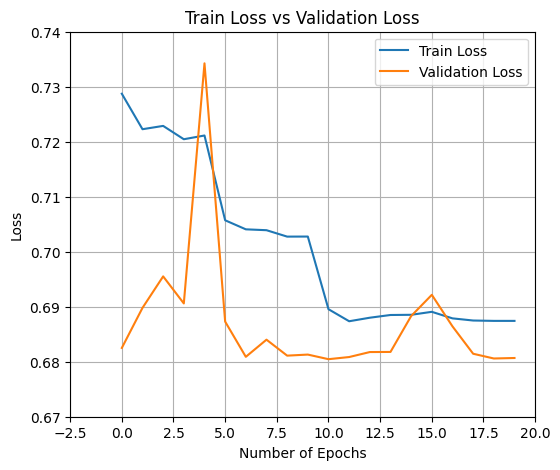

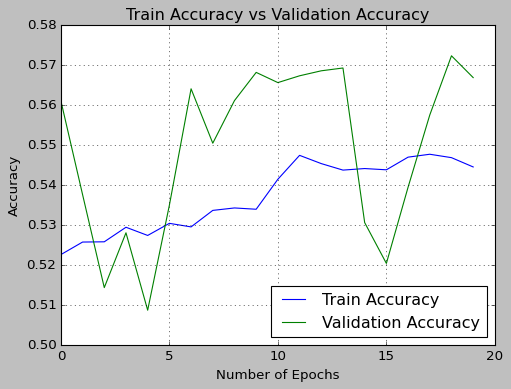

In [51]:
# Get the training history
train_loss = hist.history['loss']
val_loss = hist.history['val_loss']
train_acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']

# Get the actual number of epochs completed (based on training history length)
epochs_completed = len(train_loss)  # Or len(val_loss), as they should match

# Adjust the x range based on the actual number of epochs
epochs_range = range(epochs_completed)

# Loss plot
plt.figure(1, figsize=(6, 5))
plt.plot(epochs_range, train_loss, label='Train Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.xlabel('Number of Epochs')
plt.ylabel('Loss')
plt.title('Train Loss vs Validation Loss')
plt.grid(True)
plt.legend()
plt.style.use(['classic'])

# Accuracy plot
plt.figure(2, figsize=(7, 5))
plt.plot(epochs_range, train_acc, label='Train Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.xlabel('Number of Epochs')
plt.ylabel('Accuracy')
plt.title('Train Accuracy vs Validation Accuracy')
plt.grid(True)
plt.legend(loc=4)
plt.style.use(['classic'])

# Show the plots
plt.show()


## Validation of Model

In [52]:
# Assuming 'data_with_aug' is the ImageDataGenerator with augmentations already defined
data_with_aug = ImageDataGenerator(
    rescale=1./255,  # Rescale pixel values to [0, 1]
    rotation_range=20,  # Randomly rotate images by up to 20 degrees
    width_shift_range=0.2,  # Randomly shift images horizontally by up to 20%
    height_shift_range=0.2,  # Randomly shift images vertically by up to 20%
    shear_range=0.2,  # Randomly shear images
    zoom_range=0.2,  # Randomly zoom images
    horizontal_flip=True,  # Randomly flip images horizontally
    fill_mode='nearest',  # Fill missing pixels during augmentation
    validation_split=0.2  # Reserve 20% of data for validation
)

# Load the training data using data_with_aug for augmentation
train = data_with_aug.flow_from_directory(
    dataset_path,
    class_mode="binary",  # Binary labels for fake and real
    target_size=(224, 224),  # Resize images to 224x224 (required for ResNet)
    batch_size=32,  # Batch size for training
    subset="training"  # Use the training subset (80%)
)

# Load the validation data using data_with_aug for validation
val = data_with_aug.flow_from_directory(
    dataset_path,
    class_mode="binary",  # Binary labels for fake and real
    target_size=(224, 224),  # Resize images to 224x224
    batch_size=32,  # Batch size for validation
    subset="validation"  # Use the validation subset (20%)
)


Found 80000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.


In [53]:
resnet50_model = tf.keras.applications.ResNet50(include_top=False, 
                                                weights="imagenet", 
                                                input_shape=(224, 224, 3))

# Freeze the layers of the pre-trained model so that they won't be updated during training
for layer in resnet50_model.layers:
    layer.trainable = False

# Add custom top layers for classification
x = resnet50_model.output
x = GlobalAveragePooling2D()(x)  # Apply Global Average Pooling
x = Dropout(0.5)(x)  # Add a Dropout layer for regularization
x = Dense(1, activation="sigmoid")(x)  # Binary classification output layer

# Define the final model
model = Model(inputs=resnet50_model.input, outputs=x)

# Compile the model
model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=["accuracy"])

# Model summary
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_2[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,589,761 (89.99 MB)

 Trainable params: 2,049 (8.00 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [56]:
checkpoint = ModelCheckpoint(
    filepath="best_model.keras",    # Change file extension to .keras
    monitor='val_loss',             # Monitor validation loss
    save_best_only=True,            # Save only the model with the best (minimum) validation loss
    save_weights_only=False,        # Save the entire model (architecture + weights)
    mode='min',                     # Save when validation loss decreases
    verbose=1                       # Print a message when the model is saved
)

In [57]:
# Train the model
hist = model.fit(
    train,                          # Training data
    epochs=20,                      # Number of epochs
    callbacks=[lr_callbacks, checkpoint],  # Include learning rate scheduler and checkpoint callbacks
    validation_data=val,            # Validation data
    verbose=1                       # Verbosity mode (1 = progress bar)
)

c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5190 - loss: 0.7421
Epoch 1: val_loss improved from inf to 0.68342, saving model to best_model.keras
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 4227s 2s/step - accuracy: 0.5190 - loss: 0.7421 - val_accuracy: 0.5568 - val_loss: 0.6834 - learning_rate: 0.0100
Epoch 2/20
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 0s 924ms/step - accuracy: 0.5199 - loss: 0.7427
Epoch 2: val_loss improved from 0.68342 to 0.67944, saving model to best_model.keras
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 2877s 1s/step - accuracy: 0.5199 - loss: 0.7427 - val_accuracy: 0.5748 - val_loss: 0.6794 - learning_rate: 0.0100
Epoch 3/20
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5260 - loss: 0.7341
Epoch 3: val_loss did not improve from 0.67944
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 4435s 2s/step - accuracy: 0.5260 - loss: 0.7341 - val_accuracy: 0.5094 - val_loss: 0.7095 - learning_rate: 0.0100
Epoch 4/20
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5277 - loss: 0.7370
E

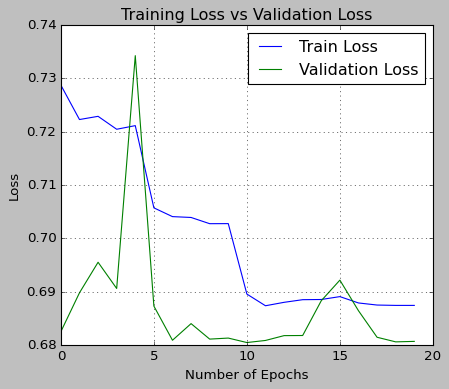

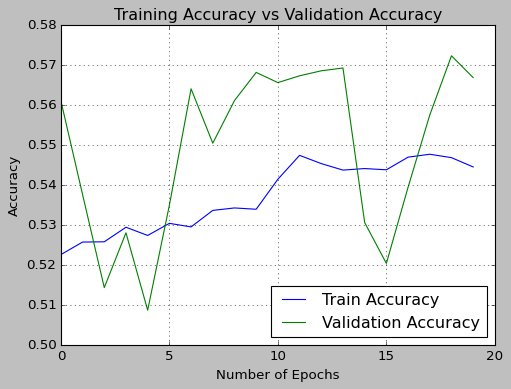

In [58]:
epochs_completed = len(hist.history['loss'])  # Get the actual number of epochs completed
xc = range(epochs_completed)  # Adjust the x-axis range dynamically

# Loss plot
plt.figure(figsize=(6, 5))
plt.plot(xc, train_loss, label='Train Loss')
plt.plot(xc, val_loss, label='Validation Loss')
plt.xlabel('Number of Epochs')
plt.ylabel('Loss')
plt.title('Training Loss vs Validation Loss')
plt.grid(True)
plt.legend(loc='upper right')
plt.style.use('classic')

# Accuracy plot
plt.figure(figsize=(7, 5))
plt.plot(xc, train_acc, label='Train Accuracy')
plt.plot(xc, val_acc, label='Validation Accuracy')
plt.xlabel('Number of Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy vs Validation Accuracy')
plt.grid(True)
plt.legend(loc=4)
plt.style.use('classic')

plt.show()


## Predictions

In [59]:
# Predict on the validation set
predictions = model.predict(val)

# Convert the probabilities to binary class labels (0 or 1)
predictions = (predictions > 0.5).astype(int)

# Print predictions
print(predictions)

625/625 ━━━━━━━━━━━━━━━━━━━━ 802s 1s/step
[[1]
 [1]
 [1]
 ...
 [1]
 [0]
 [1]]


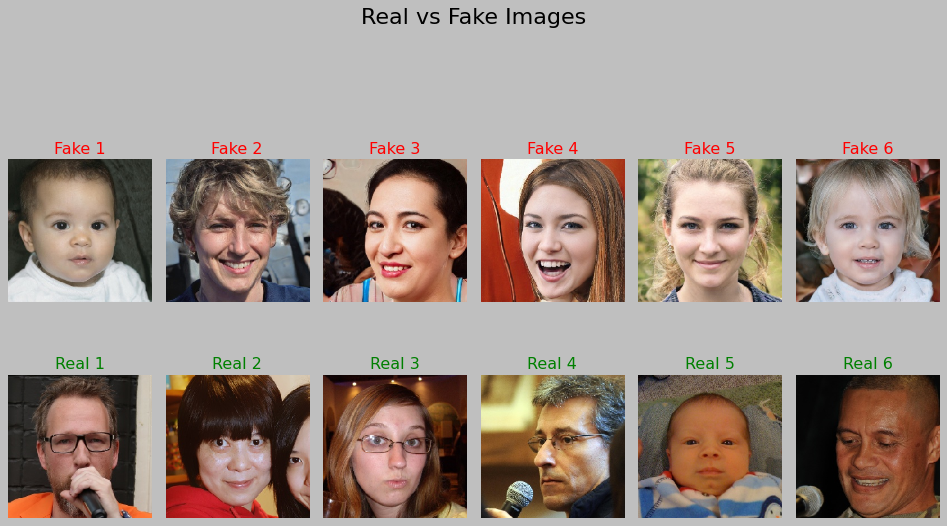

In [69]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img
import os

# Define the paths to the validation images (fake and real subfolders)
val_fake_path = "D:\\DEEPFAKES\\dataset\\real_vs_fake\\real-vs-fake\\valid\\fake"
val_real_path = "D:\\DEEPFAKES\\dataset\\real_vs_fake\\real-vs-fake\\valid\\real"

# List the image files in both directories
fake_files = os.listdir(val_fake_path)
real_files = os.listdir(val_real_path)

# Display a maximum of 6 images from each directory
num_images_to_display = 6

# Create a figure to display the images in a grid layout (2 rows, 6 images each)
plt.figure(figsize=(12, 8))
plt.suptitle("Real vs Fake Images", fontsize=20)

# Display Fake Images (first 6)
for i in range(num_images_to_display):
    fake_img_path = os.path.join(val_fake_path, fake_files[i])
    plt.subplot(2, num_images_to_display, i + 1)  # Row 1 for fake images
    try:
        fake_img = load_img(fake_img_path, target_size=(224, 224))  # Resize image
        plt.imshow(fake_img)
        plt.title(f"Fake {i + 1}", color='red')  # Title for fake images
        plt.axis('off')
    except Exception as e:
        print(f"Error loading fake image {fake_img_path}: {e}")

# Display Real Images (next 6)
for i in range(num_images_to_display):
    real_img_path = os.path.join(val_real_path, real_files[i])
    plt.subplot(2, num_images_to_display, i + 7)  # Row 2 for real images
    try:
        real_img = load_img(real_img_path, target_size=(224, 224))  # Resize image
        plt.imshow(real_img)
        plt.title(f"Real {i + 1}", color='green')  # Title for real images
        plt.axis('off')
    except Exception as e:
        print(f"Error loading real image {real_img_path}: {e}")

# Display all the images
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to fit title
plt.show()
